[View in Colaboratory](https://colab.research.google.com/github/mari-linhares/tensorflow-brasil/blob/eager-hub/classificador_caes_e_gatos_eager.ipynb)

# Classificador de Imagens usando TensorFlow

[Jupyter notebook no Github]()

Neste notebook iremos implementar um modelo para classificação de imagens. Classificação é uma dos casos de uso de Machine Learning, nesta tarefa o ensino é supervisionado, em outras palavras nós vamos ensinar ao modelo através de exemplos com gabarito.

Nosso modelo deverá receber imagens de gatos e cachorros e identificar a que classe (gato ou cachorro) estas imagens pertencem.

## Dados
Os dados foram retirados da [tarefa 1 do curso MOC do Fast.AI](http://course.fast.ai/lessons/lesson1.html), estamos usando uma amostra do dataset para treinar mais rápido.

Nessa amostra temos:

* ~2000 imagens de treino (~1000 gatos e ~1000 cachorros)
* ~2000 imagens de teste  (~1000 gatos e ~1000 chachorros)


## Modelo
Iremos utilizar diferentes modelos com diferentes níveis de complexidade.

## Créditos

Essa atividade é baseada em vários trabalhos já existentes e adaptados, alguns desses materiais são:
* no notebook encontrado aqui implementada originalmente por @chrisying.
* Colab sobre TensorFlow Hub por [Damien Pontifex](https://colab.research.google.com/github/damienpontifex/BlogCodeSamples/blob/master/TransferLearning/TfHubDogsVsCats.ipynb#scrollTo=bgYkTngWfKrG)
* Palestra sobre Eager mode e High Level APIs no Google I/O 2018

Obrigada a todos os envolvidos!

## Dependências

### Instalando TensorFlow 1.8.0

Esse tutorial usa TensorFlow Eager mode, que está apenas disponível a partir do TensorFlow 1.8 **Após executar o código abaixo você precisa reiniciar o Runtime ou Kernel (Jupyter notebook)**.

In [17]:
!pip install --upgrade --force tensorflow==1.8.0

  Using cached https://files.pythonhosted.org/packages/c6/0e/8af18d9169ed4f1a1c72cd50defd95b8382a12f2cf7cb9b76ba053db79ad/tensorflow-1.8.0-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/2a/d5/eb371e43d65989267a9daa90ee8f92d79b216184ea3c8cf0670e5c2388eb/grpcio-1.12.0-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/e6/35/f187bdf23be87092bd0f1200d43d23076cee4d0dec109f195173fd3ebc79/mock-2.0.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/9d/61/54c3a9cfde6ffe0ca6a1786ddb8874263f4ca32e7693ad383bd8cf935015/protobuf-3.5.2.post1-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/81/30/e935244ca6165187ae8be876b6316ae201b71485538ffac1d718843025a9/wheel-0.31.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/88/ec/f598b633c3d5ffe267aaada57d961c94fdfa183c5c3ebda2b6d151943db6/backports.weakref-1.0.post1-py2.py3-none-any.whl

      Successfully uninstalled setuptools-39.2.0
  Found existing installation: protobuf 3.5.2.post1
    Uninstalling protobuf-3.5.2.post1:
      Successfully uninstalled protobuf-3.5.2.post1
  Found existing installation: gast 0.2.0
    Uninstalling gast-0.2.0:
      Successfully uninstalled gast-0.2.0
  Found existing installation: wheel 0.31.1
    Uninstalling wheel-0.31.1:
      Successfully uninstalled wheel-0.31.1
  Found existing installation: absl-py 0.2.1
    Uninstalling absl-py-0.2.1:
      Successfully uninstalled absl-py-0.2.1
  Found existing installation: backports.weakref 1.0.post1
    Uninstalling backports.weakref-1.0.post1:
      Successfully uninstalled backports.weakref-1.0.post1
  Found existing installation: html5lib 0.9999999
    Uninstalling html5lib-0.9999999:
      Successfully uninstalled html5lib-0.9999999
  Found existing installation: bleach 1.5.0
    Uninstalling bleach-1.5.0:
      Successfully uninstalled bleach-1.5.0
  Found existing installation: num

#### Importando TensorFlow

Se a GPU do Colab estiver disponível você deve ver algo do tipo: **/device:GPU:0** na saída abaixo:

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import tensorflow.contrib.eager as tfe
tf.test.gpu_device_name()

''

### Instalando demais dependências

In [3]:
 !pip install pillow matplotlib numpy pandas

#### Importando dependências

In [2]:
# Compatibilidade entre Python 2 e Python 3
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
import os
try:
  import urllib.request as urrlib_request # Python 3
except:
  import urllib as urllib_request  # Python 2
import tarfile
import zipfile


# TensorFlow
tf.logging.set_verbosity(tf.logging.INFO)  # Permitindo visualização de logs

# Bibliotecas auxiliares
try:
  import cPickle  # maior eficiência ao processar as imagens
except:
  import _pickle as cPickle

import numpy as np  # manipular vetores
from PIL import Image  # lidar com imagens
import matplotlib.pyplot as plt  # plotar imagens
%matplotlib inline

import glob  # lidar com arquivos

tf.logging.info('Recomenda-se para esta atividade uma versão >= 1.8.0')
tf.logging.info('Sua versão do TensorFlow {}'.format(tf.__version__))
tf.logging.info('GPU disponível? {}'.format('Sim' if tf.test.is_gpu_available() else 'Não'))

INFO:tensorflow:Recomenda-se para esta atividade uma versão >= 1.8.0
INFO:tensorflow:Sua versão do TensorFlow 1.8.0
INFO:tensorflow:GPU disponível? Não


## Buscando e tratando os dados

Pode ignorar essa parte do código caso seu foco seja apenas aprender mais sobre TensorFlow especificamente. Aqui o que é feito é:
* Os dados são baixados caso necessário.
* As imagens são tratadas: shapes corrigidas, valores normalizados...


### Baixando os dados

O código abaixo foi basicamente copiado diretamente de: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/download.py pois esse não é o foco desse tutorial.

In [0]:
def _print_download_progress(count, block_size, total_size):
  """
  Function used for printing the download progress.
  Used as a call-back function in maybe_download_and_extract().
  """

  # Percentage completion.
  pct_complete = float(count * block_size) / total_size

  # Status-message. Note the \r which means the line should overwrite itself.
  msg = "\r- Download progress: {0:.1%}".format(pct_complete)

  # Print it.
  sys.stdout.write(msg)
  sys.stdout.flush()


def maybe_download_and_extract(url="https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz",
                               download_dir="."):
  """
  Download and extract the data if it doesn't already exist.
  Assumes the url is a tar-ball file.
  :param url:
      Internet URL for the tar-file to download.
      Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
  :param download_dir:
      Directory where the downloaded file is saved.
      Example: "data/CIFAR-10/"
  :return:
      Nothing.
  """

  # Filename for saving the file downloaded from the internet.
  # Use the filename from the URL and add it to the download_dir.
  filename = url.split('/')[-1]
  file_path = os.path.join(download_dir, filename)

  # Check if the file already exists.
  # If it exists then we assume it has also been extracted,
  # otherwise we need to download and extract it now.
  if not os.path.exists(file_path):
      # Check if the download directory exists, otherwise create it.
      if not os.path.exists(download_dir):
          os.makedirs(download_dir)

      # Download the file from the internet.
      file_path, _ = urllib_request.urlretrieve(url=url,
                                                filename=file_path,
                                                reporthook=_print_download_progress)

      print()
      print("Download finished. Extracting files.")

      if file_path.endswith(".zip"):
          # Unpack the zip-file.
          zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
      elif file_path.endswith((".tar.gz", ".tgz")):
          # Unpack the tar-ball.
          tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

      print("Done.")
  else:
      print("Data has apparently already been downloaded and unpacked.")


In [4]:
maybe_download_and_extract(url='http://files.fast.ai/data/dogscats.zip')

Data has apparently already been downloaded and unpacked.


In [5]:
!ls                     # checando se a nova pasta foi criada
!ls 'dogscats/'         # checando o que tem dentro dela
DATA_DIR = 'dogscats/'  # "apontando" para nova pasta

datalab  dogscats  dogscats.zip  logdir
models	sample	test1  train  valid


#### Visualizando algumas imagens do dataset e seus labels

In [6]:
# Temos cada imagem individualmente
gatos = glob.glob(os.path.join(DATA_DIR, 'train', 'cats', '*'))[:5]
gatos

['dogscats/train/cats/cat.5845.jpg',
 'dogscats/train/cats/cat.1903.jpg',
 'dogscats/train/cats/cat.4114.jpg',
 'dogscats/train/cats/cat.10578.jpg',
 'dogscats/train/cats/cat.985.jpg']

Exemplo de 6 imagens da base de treino
numero de gatos no treino completo: 11500 numero de caes no treino completo: 11500


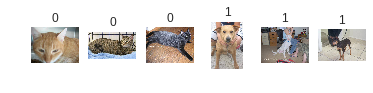

In [7]:
def visualizar_dados_treino(num_imgs_por_classe, data_dir):
    '''Essa função apresenta alguns dados de treino (imagens, labels) escolhidos aleatoriamente.
       Parâmetros:
           num_imgs_por_classe (int): número de imagens apresentadas por classe.
           data_dir (string): onde os arquivos foram baixados.
    '''

    print('Exemplo de %d imagens da base de treino' % (num_imgs_por_classe * 2))
    
    # Obtemos as imagens
    treino_path = os.path.join(data_dir, 'train')
    gatos = os.listdir(os.path.join(treino_path, 'cats'))
    caes = os.listdir(os.path.join(treino_path, 'dogs'))
    
    # Escolhemos índices aleatórios
    print('numero de gatos no treino completo:', len(gatos), 'numero de caes no treino completo:', len(caes))
    random_ind_gato = np.random.choice(len(gatos), num_imgs_por_classe, replace=False)
    random_ind_cao = np.random.choice(len(caes), num_imgs_por_classe, replace=False)
    
    # Buscando imagens e labels
    imagens = [gatos[r] for r in random_ind_gato] + [caes[r] for r in random_ind_cao]
    labels = [0] * num_imgs_por_classe + [1] * num_imgs_por_classe
    
    # Plottando imagens
    for index, (img, label) in enumerate(zip(imagens, labels)):
        if 'cat' in img:
          path = os.path.join(treino_path, 'cats')
        else:
          path = os.path.join(treino_path, 'dogs')
        
        img = plt.imread(os.path.join(path, img))
        
        plt.subplot(4, num_imgs_por_classe * 2, index + 1)
        plt.axis('off')
        plt.imshow(img, cmap=plt.cm.gray_r)
        plt.title('%i' % label)
    plt.show()

visualizar_dados_treino(3, DATA_DIR)

As imagens são maiores do que parecem! Abaixo temos um exemplo de uma única imagem.

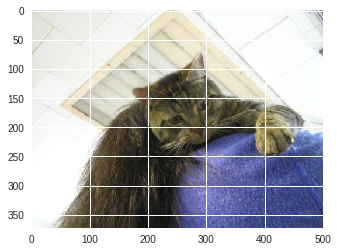

In [8]:
img = plt.imread(gatos[0])
plt.imshow(img)

### Baixando dados para predição

In [16]:
# algumas imagens para testarmos os modelos%
path_principal = "https://github.com/mari-linhares/tensorflow-brasil/blob/master/classificador-cachorros-gatos-estimator/imgs/%s?raw=true"
pred_imagens = ["cao2.jpg", "cao_e_gato.jpg", "cat.jpg", "dog.jpg", "gato2.jpg", "gato3.jpg"]

paths = [path_principal % img for img in pred_imagens]

# baixar imagens
for path, img in zip(paths, pred_imagens):
  urllib_request.urlretrieve(path, img)

!ls

cao2.jpg	cat.jpg  dog.jpg   dogscats.zip  gato3.jpg
cao_e_gato.jpg	datalab  dogscats  gato2.jpg	 logdir


### Usando Tf.data para lidar com os dados!

Tf.data é uma api fléxivel e rápida que permite manipular desde uma pequena quantidade de dados até dados que não cabem na memória. 

In [0]:
def _img_string_to_tensor(image_string, image_size=(299, 299)):
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    # Converte int8 -> [0,1] de float32.
    image_decoded_as_float = tf.image.convert_image_dtype(image_decoded, dtype=tf.float32)
    # Imagens deve ter uma dimensao fixa para serem treinadas!
    image_resized = tf.image.resize_images(image_decoded_as_float, size=image_size)
    
    return image_resized

def get_dataset(file_pattern, image_size=(224, 224), shuffle=False,
                batch_size=64, num_epochs=None, buffer_size=4096):
    def _path_to_img(path):
        # A classe nesse caso será dada pela pasta em que a imagem está
        # geralmente o column é já guardar esses dados em algum formato tabular
        # ou textual com as labels indexadas (0, 1, 2, ...)
        label = tf.string_split([path], delimiter='/').values[-2]
        # Lê imagem do disco
        image_string = tf.read_file(path)
        image_resized = _img_string_to_tensor(image_string, image_size)
        
        return image_resized, label, path  # retornando path apenas para saber qual é a imagem

    # Cria um dataset de uma lista de arquivos
    dataset = tf.data.Dataset.list_files(file_pattern)

    # Para o treino sempre queremos randomizar a ordem dos dados!
    if shuffle:
        dataset = dataset.apply(tf.contrib.data.shuffle_and_repeat(buffer_size, num_epochs))
    else:
        dataset = dataset.repeat(num_epochs)

    dataset = dataset.map(_path_to_img)  # conversão imagem -> dado tabular, label
    dataset = dataset.batch(batch_size).prefetch(buffer_size)

    return dataset

### Verificando se dados foram salvos corretamente

Após manipular ou modificar os dados é sempre importante garantir que os dados estão no formato esperado e não foram corrompidos ou alterados indevidamente. Para isto vamos escolher algumas imagens do conjunto de treino aleatoriamente e verificá-las.

> IMPORTANTE: para modelos reais é importante garantir a qualidade e integridade dos dados com maior rigor já que é fundamental a "saúde" dos dados para se obter um bom modelo.

## Implementando os modelos!

Iremos implementar 4 diferentes abordagens para o nosso problema:
* Rede neural com Keras
* Árvore de decisão com Estimators
* Rede neural convolucional com Keras
* Transfer learning com Tf.hub

### Rede neural com Keras + Eager mode


#### Funções e parâmetros auxiliares

In [0]:
H = 32            # pode mudar caso queira, deixei 32 para treinar mais rápido
W = 32            # pode mudar caso queira, deixei 32 para treinar mais rápido

BATCH_SIZE = 64  # numero de imagens processadas em cada iteração (pode mudar)

num_epochs = 5        # numero de iterações no dataset

FLAT_DIM = H * W * 3  # para a rede neural temos que passar a imagem como um vetor
def flat_x(x, batch_size=BATCH_SIZE):
  batch_size = min(batch_size, x.shape[0])
  return tf.reshape(x, (batch_size, FLAT_DIM))

def str_to_idx(y):
  return [1 if aux.numpy() == 'cats' else 0 for aux in y]

In [59]:
# o filtro .8 é apenas para diminuir o tamanho do treino para treinar mais rápido
train_files = os.path.join(DATA_DIR, 'train/', '**/*8.jpg')
test_files = os.path.join(DATA_DIR, 'valid', '**/*.jpg')

print('tamanho do treino:', len(glob.glob(train_files)))
print('tamanho do teste:', len(glob.glob(test_files)))


train_ds = get_dataset(train_files, batch_size=BATCH_SIZE, shuffle=True, image_size=(H, W), num_epochs=1)
test_ds = get_dataset(test_files, batch_size=BATCH_SIZE, image_size=(H, W), num_epochs=1, shuffle=False)
pred_ds = get_dataset(pred_imagens, batch_size=1, image_size=(H, W), num_epochs=1, shuffle=False)

tamanho do treino: 2303
tamanho do teste: 2000


#### Modelo propriamente dito

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(FLAT_DIM, activation="relu", input_shape=(BATCH_SIZE, FLAT_DIM)),  # input shape required
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(2)
])

def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)


def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, model.variables)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)  # Gradiente Descentende simples, na prática algum algoritmo similar "mais poderoso"

#### Treinamento + Avaliação   

In [76]:
train_loss_results = []      # guardar resultados
train_accuracy_results = []  # guardar resultados

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()

    for i, (x, y, _) in enumerate(train_ds):
      # Otimizar modelo
      x = flat_x(x)
      y = str_to_idx(y)

      grads = grad(model, x, y)
      optimizer.apply_gradients(zip(grads, model.variables),
                                global_step=tf.train.get_or_create_global_step())

      # IMPORTANTE: observar métricas durante o treino
      l = loss(model, x, y)
      output = model(x)

      epoch_loss_avg(l)  # add current batch loss
      # compare predicted label to actual label
      epoch_accuracy(tf.argmax(output, axis=1, output_type=tf.int32), y)

      if i % 10 == 0:
        print('Train epoch %d, step %d, Loss: %.4f' % (epoch, i, l))

    # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    test_accuracy = tfe.metrics.Accuracy()

    for (x, y, _) in test_ds:
      x = flat_x(x)
      y = str_to_idx(y)
      prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
      test_accuracy(prediction, y)

    print("Test set accuracy: {:.3%}".format(test_accuracy.result()))
    print("Epoch {:03d}: Train Loss: {:.3f}, Train Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Train epoch 0, step 0, Loss: 0.6772
Train epoch 0, step 10, Loss: 0.6505
Train epoch 0, step 20, Loss: 0.6479
Train epoch 0, step 30, Loss: 0.6193
Test set accuracy: 55.300%
Epoch 000: Train Loss: 0.648, Train Accuracy: 63.873%
Train epoch 1, step 0, Loss: 0.6446
Train epoch 1, step 10, Loss: 0.6347
Train epoch 1, step 20, Loss: 0.6089
Train epoch 1, step 30, Loss: 0.6059
Test set accuracy: 59.200%
Epoch 001: Train Loss: 0.633, Train Accuracy: 66.348%
Train epoch 2, step 0, Loss: 0.6113
Train epoch 2, step 10, Loss: 0.6321
Train epoch 2, step 20, Loss: 0.5596
Train epoch 2, step 30, Loss: 0.6091
Test set accuracy: 60.400%
Epoch 002: Train Loss: 0.620, Train Accuracy: 67.694%
Train epoch 3, step 0, Loss: 0.6647
Train epoch 3, step 10, Loss: 0.6298
Train epoch 3, step 20, Loss: 0.6305
Train epoch 3, step 30, Loss: 0.5973
Test set accuracy: 60.950%
Epoch 003: Train Loss: 0.614, Train Accuracy: 68.432%
Train epoch 4, step 0, Loss: 0.5566
Train epoch 4, step 10, Loss: 0.6312
Train epoch 4, 

Train epoch 13, step 10, Loss: 0.5106
Train epoch 13, step 20, Loss: 0.5199
Train epoch 13, step 30, Loss: 0.5888
Test set accuracy: 55.650%
Epoch 013: Train Loss: 0.538, Train Accuracy: 74.902%
Train epoch 14, step 0, Loss: 0.6006
Train epoch 14, step 10, Loss: 0.5256
Train epoch 14, step 20, Loss: 0.5260
Train epoch 14, step 30, Loss: 0.5413
Test set accuracy: 62.450%
Epoch 014: Train Loss: 0.539, Train Accuracy: 74.294%
Train epoch 15, step 0, Loss: 0.4733
Train epoch 15, step 10, Loss: 0.5411
Train epoch 15, step 20, Loss: 0.5417
Train epoch 15, step 30, Loss: 0.5570
Test set accuracy: 62.900%
Epoch 015: Train Loss: 0.530, Train Accuracy: 75.727%
Train epoch 16, step 0, Loss: 0.5028
Train epoch 16, step 10, Loss: 0.4974
Train epoch 16, step 20, Loss: 0.5419
Train epoch 16, step 30, Loss: 0.4780
Test set accuracy: 61.750%
Epoch 016: Train Loss: 0.527, Train Accuracy: 75.727%
Train epoch 17, step 0, Loss: 0.4695
Train epoch 17, step 10, Loss: 0.4805
Train epoch 17, step 20, Loss: 0.4

### Predição

Probabilidade de ser cao ou gato: [[0.45061132 0.5493887 ]]
Label predita: gato


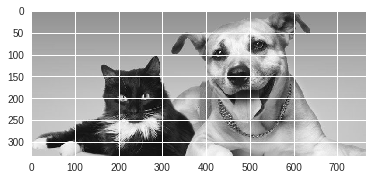

Probabilidade de ser cao ou gato: [[0.46195912 0.5380408 ]]
Label predita: gato


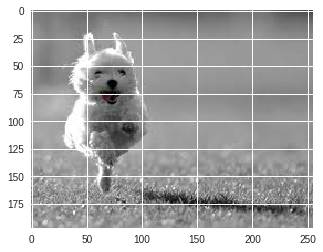

Probabilidade de ser cao ou gato: [[0.38074842 0.6192516 ]]
Label predita: gato


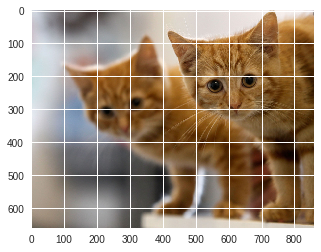

Probabilidade de ser cao ou gato: [[0.17700064 0.8229993 ]]
Label predita: gato


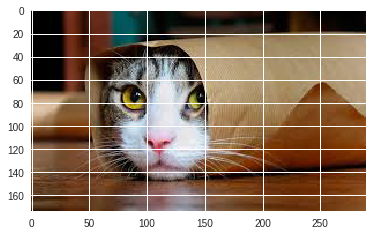

Probabilidade de ser cao ou gato: [[0.5890513 0.4109487]]
Label predita: cao


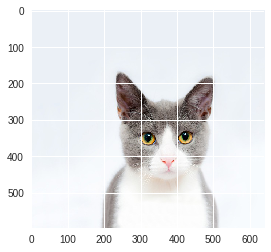

Probabilidade de ser cao ou gato: [[0.62674636 0.37325364]]
Label predita: cao


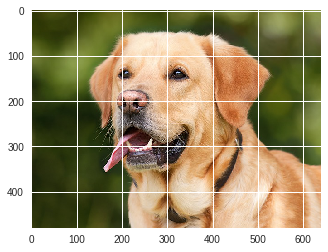

In [77]:
%matplotlib inline
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=1)

for i, (x, y, path) in enumerate(pred_ds):
    x = flat_x(x)
  
    output = model(x) # saida do modelo
    prediction = tf.argmax(softmax(output), axis=1, output_type=tf.int32)  # predicao é o maior valor dps de aplicado softmax
    print('Probabilidade de ser cao ou gato:', softmax(output))
    print('Label predita:', 'gato' if prediction.numpy() == [1] else 'cao')
    
    # Plotar imagem
    img = plt.imread(path.numpy()[0])
    plt.imshow(img)
    plt.show()

### Rede Neural Convolucional com Keras

Muito difícil mudar pra uma rede neural convolucional? Única coisa que muda é a definição do modelo :)!

In [70]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation="relu", input_shape=(H, W, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.MaxPooling2D(),  
  tf.keras.layers.Conv2D(64, 3, activation="relu"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(2)
])

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

num_epochs = 20  # precisamos de mais epochs para ver o poder da CNN em ação :)

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()

    for i, (x, y, _) in enumerate(train_ds):
      # Optimize the model
      y = str_to_idx(y)
      grads = grad(model, x, y)
      optimizer.apply_gradients(zip(grads, model.variables),
                                global_step=tf.train.get_or_create_global_step())

      # Track progress
      l = loss(model, x, y)
      output = model(x)
      
      epoch_loss_avg(l)  # add current batch loss
      # compare predicted label to actual label
      epoch_accuracy(tf.argmax(output, axis=1, output_type=tf.int32), y)
      
      if i % 10 == 0:
        print('Train epoch %d, step %d, Loss: %.4f' % (epoch, i, l))


    # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
      
    # model_test_output = softmax_model(dados_teste['imagens'])
    # model_test_label = dados_treino['labels']
    # correct_prediction = tf.equal(tf.argmax(model_test_output, 1), tf.argmax(model_test_label, 1))
    # accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    test_accuracy = tfe.metrics.Accuracy()

    for (x, y, _) in test_ds:
      y = str_to_idx(y)
      prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
      test_accuracy(prediction, y)

    print("Test set accuracy: {:.3%}".format(test_accuracy.result()))
    print("Epoch {:03d}: Train Loss: {:.3f}, Train Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Train epoch 0, step 0, Loss: 0.6990
Train epoch 0, step 10, Loss: 0.6913
Train epoch 0, step 20, Loss: 0.6868
Train epoch 0, step 30, Loss: 0.6927
Test set accuracy: 54.950%
Epoch 000: Train Loss: 0.692, Train Accuracy: 51.889%
Train epoch 1, step 0, Loss: 0.6895
Train epoch 1, step 10, Loss: 0.6896
Train epoch 1, step 20, Loss: 0.6922
Train epoch 1, step 30, Loss: 0.6943
Test set accuracy: 56.200%
Epoch 001: Train Loss: 0.691, Train Accuracy: 53.843%
Train epoch 2, step 0, Loss: 0.6921
Train epoch 2, step 10, Loss: 0.6872
Train epoch 2, step 20, Loss: 0.6859
Train epoch 2, step 30, Loss: 0.6900
Test set accuracy: 55.750%
Epoch 002: Train Loss: 0.690, Train Accuracy: 56.448%
Train epoch 3, step 0, Loss: 0.6937
Train epoch 3, step 10, Loss: 0.6910
Train epoch 3, step 20, Loss: 0.6912
Train epoch 3, step 30, Loss: 0.6840
Test set accuracy: 55.850%
Epoch 003: Train Loss: 0.689, Train Accuracy: 56.188%
Train epoch 4, step 0, Loss: 0.6892
Train epoch 4, step 10, Loss: 0.6863
Train epoch 4, 

Train epoch 13, step 10, Loss: 0.6746
Train epoch 13, step 20, Loss: 0.6754
Train epoch 13, step 30, Loss: 0.6917
Test set accuracy: 59.800%
Epoch 013: Train Loss: 0.683, Train Accuracy: 60.443%
Train epoch 14, step 0, Loss: 0.6817
Train epoch 14, step 10, Loss: 0.6809
Train epoch 14, step 20, Loss: 0.6792
Train epoch 14, step 30, Loss: 0.6948
Test set accuracy: 59.200%
Epoch 014: Train Loss: 0.682, Train Accuracy: 59.357%
Train epoch 15, step 0, Loss: 0.6788
Train epoch 15, step 10, Loss: 0.6811
Train epoch 15, step 20, Loss: 0.6817
Train epoch 15, step 30, Loss: 0.6946
Test set accuracy: 60.500%
Epoch 015: Train Loss: 0.682, Train Accuracy: 61.007%
Train epoch 16, step 0, Loss: 0.6756
Train epoch 16, step 10, Loss: 0.6793
Train epoch 16, step 20, Loss: 0.6799
Train epoch 16, step 30, Loss: 0.6808
Test set accuracy: 61.050%
Epoch 016: Train Loss: 0.681, Train Accuracy: 60.182%
Train epoch 17, step 0, Loss: 0.6783
Train epoch 17, step 10, Loss: 0.6787
Train epoch 17, step 20, Loss: 0.6

### Predição

Probabilidade de ser cao ou gato: [[0.4733208  0.52667916]]
Label predita: gato


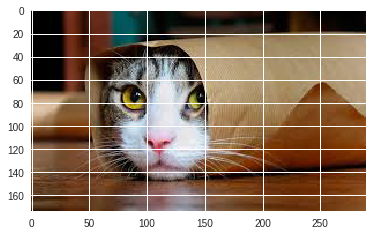

Probabilidade de ser cao ou gato: [[0.535097   0.46490297]]
Label predita: cao


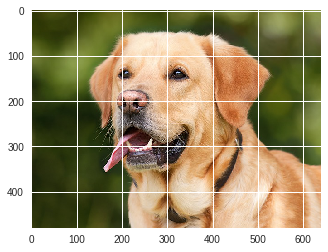

Probabilidade de ser cao ou gato: [[0.505418   0.49458194]]
Label predita: cao


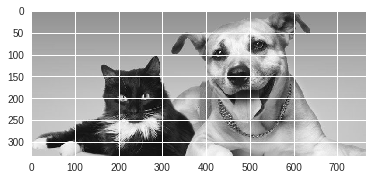

Probabilidade de ser cao ou gato: [[0.52616274 0.47383723]]
Label predita: cao


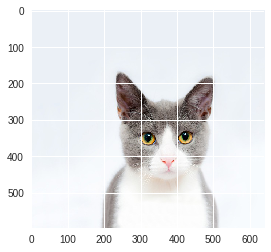

Probabilidade de ser cao ou gato: [[0.54627806 0.45372194]]
Label predita: cao


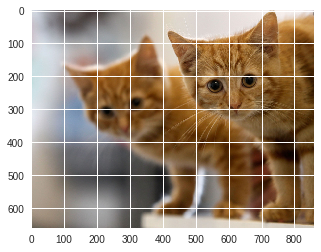

Probabilidade de ser cao ou gato: [[0.48582548 0.5141745 ]]
Label predita: gato


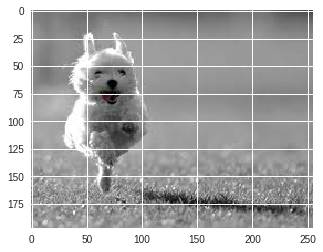

In [72]:
%matplotlib inline
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=1)

for i, (x, y, path) in enumerate(pred_ds):
    output = model(x) # saida do modelo
    prediction = tf.argmax(softmax(output), axis=1, output_type=tf.int32)  # predicao é o maior valor dps de aplicado softmax
    print('Probabilidade de ser cao ou gato:', softmax(output))
    print('Label predita:', 'gato' if prediction.numpy() == [1] else 'cao')
    
    # Plotar imagem
    img = plt.imread(path.numpy()[0])
    plt.imshow(img)
    plt.show()

### Transfer Learning com TensorFlow Hub

Disponível nesse outro codelab: https://colab.research.google.com/drive/1cy7-oRXEzsxbH5b9DS5H0gGwMgxntkn8